# <center> Финальное задание </center>
## <center> Предсказание пола клиента по транзакциям</center>

## Описание задачи 
### В рамках задания необходимо предсказывать пол клиента, основываясь на его транзакционных исторических данных. 
### В роли метрики выступает [ROC AUC](https://dyakonov.org/2017/07/28/auc-roc-%D0%BF%D0%BB%D0%BE%D1%89%D0%B0%D0%B4%D1%8C-%D0%BF%D0%BE%D0%B4-%D0%BA%D1%80%D0%B8%D0%B2%D0%BE%D0%B9-%D0%BE%D1%88%D0%B8%D0%B1%D0%BE%D0%BA/), который и нужно оптимизировать.

In [71]:
import pandas as pd
import numpy as np
import xgboost as xgb
import re
import matplotlib.pyplot as plt

from tqdm._tqdm_notebook import tqdm_notebook
from warnings import filterwarnings

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок


%matplotlib inline
filterwarnings('ignore')

### Скачать данные можно по ссылке:
https://drive.google.com/drive/folders/144e17cIljTFPhUGQ9urJVtpItFniGAvJ?usp=sharing

In [72]:
# Считываем данные
tr_mcc_codes = pd.read_csv('Data/tr_mcc_codes.csv', sep=';', index_col='mcc_code')
tr_types = pd.read_csv('Data/tr_types.csv', sep=';', index_col='tr_type')

transactions = pd.read_csv('Data/transactions.csv', index_col='customer_id')
gender_train = pd.read_csv('Data/gender_train.csv', index_col='customer_id')
gender_test = pd.read_csv('Data/gender_test.csv', index_col='customer_id')
transactions_train = transactions.join(gender_train, how='inner')
transactions_test = transactions.join(gender_test, how='inner')

In [73]:
transactions_train.head()

,tr_datetime,mcc_code,tr_type,amount,term_id,gender
customer_id,,,,,,
22899,1 15:26:45,4814,1030,-4491.83,NaN,1
22899,2 20:52:48,4814,1030,-2245.92,NaN,1
22899,5 18:52:19,6011,2010,-44918.32,NaN,1
22899,6 12:28:22,6011,2010,-150476.36,NaN,1
22899,28 10:41:01,6010,7030,33688.74,NaN,1


### Определяем полезные функции

In [74]:
def cv_score(params: dict, train: pd.DataFrame, y_true: pd.Series):
    '''
    Cross-validation score (среднее значение метрики ROC AUC на тренировочных данных)
    '''
    cv_res=xgb.cv(params, xgb.DMatrix(train, y_true),
                  early_stopping_rounds=10, maximize=True, 
                  num_boost_round=10000, nfold=5, stratified=True)
    index_argmax = cv_res['test-auc-mean'].argmax()
    print('Cross-validation, ROC AUC: {:.3f}+-{:.3f}, Trees: {}'.format(cv_res.loc[index_argmax]['test-auc-mean'],
                                                                        cv_res.loc[index_argmax]['test-auc-std'],
                                                                        index_argmax))

def fit_predict(params: dict, num_trees: int, train: pd.DataFrame, test: pd.DataFrame, target: pd.Series) -> tuple:
    '''
    Построение модели + возврат результатов классификации тестовых пользователей
    '''
    params['learning_rate'] = params['eta']
    clf = xgb.train(params, xgb.DMatrix(train.values, target, feature_names=list(train.columns)), 
                    num_boost_round=num_trees, maximize=True)
    y_pred = clf.predict(xgb.DMatrix(test.values, feature_names=list(train.columns)))
    submission = pd.DataFrame(index=test.index, data=y_pred, columns=['probability'])
    return clf, submission


def draw_feature_importances(clf, top_k=10):
    '''
    Отрисовка важности переменных
    '''
    plt.figure(figsize=(10, 10))
    
    importances = dict(sorted(clf.get_score().items(), key=lambda x: x[1])[-top_k:])
    y_pos = np.arange(len(importances))
    
    plt.barh(y_pos, list(importances.values()), align='center', color='green')
    plt.yticks(y_pos, importances.keys(), fontsize=12)
    plt.xticks(fontsize=12)
    plt.xlabel('Feature importance', fontsize=15)
    plt.title('Features importances, Sberbank Gender Prediction', fontsize=18)
    plt.ylim(-0.5, len(importances) - 0.5)
    plt.show()

## Basic features
Начнём с того, что сформируем базовые переменные по каждому пользователю. На этом этапе будем использовать стандартные агрегации, посчитанные на расходах и приходах клиента:
- минимум
- максимум
- среднее
- медиана
- среднеквадратичное отклонение
- количество

Также параметры модели выберем стандартные, запишем их в словарь params, и будем использовать для дальнейшего построения модели.

In [75]:
params = {
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    
    'gamma': 0,
    'lambda': 0,
    'alpha': 0,
    'min_child_weight': 0,
    
    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'tree_method': 'approx'
}

In [76]:
tqdm_notebook.pandas(desc="Progress:")

def features_creation_basic(x): 
    features = []
    features.append(pd.Series(x[x['amount']>0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('positive_transactions_')))
    features.append(pd.Series(x[x['amount']<0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('negative_transactions_')))
 
    return pd.concat(features)

data_train = transactions_train.groupby(transactions_train.index).progress_apply(features_creation_basic)
data_test = transactions_test.groupby(transactions_test.index).progress_apply(features_creation_basic)

Progress::   0%|          | 0/8400 [00:00<?, ?it/s]

Progress::   0%|          | 0/3600 [00:00<?, ?it/s]

In [77]:
#Отдельно определяем target:
target = data_train.join(gender_train, how='inner')['gender']

In [78]:
#Запускаем cross валидацию:
cv_score(params, data_train, target)

Cross-validation, ROC AUC: 0.622+-0.002, Trees: 54


In [79]:
### Число деревьев для XGBoost имеет смысл выставлять по результатам на кросс-валидации 
clf, submission = fit_predict(params, 54, data_train, data_test, target)

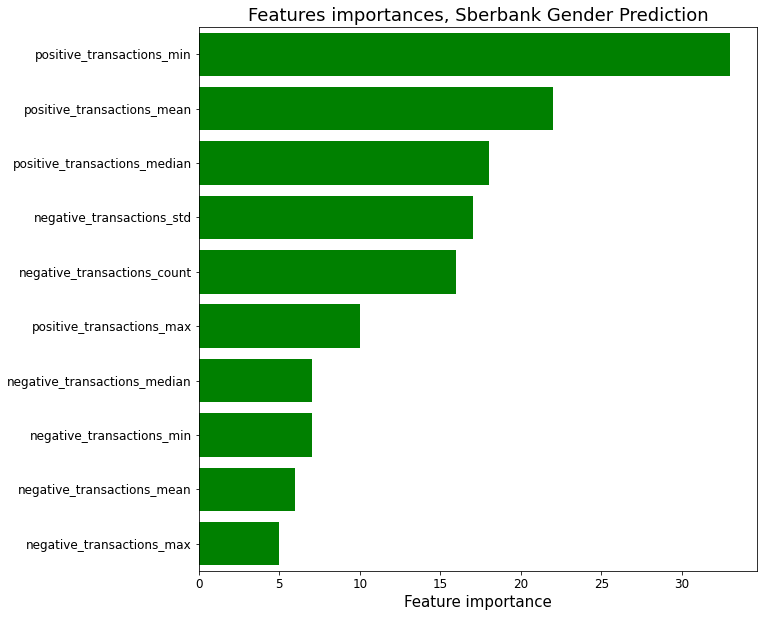

In [80]:
draw_feature_importances(clf, 10)

In [81]:
#submission.to_csv('../data/basic_features_submission.csv')

### Видим, что результат на кросс-валидации - 62.2% ROC AUC.

## Advanced features
Добавим дополнительные переменные по каждому пользователю в модель. <br>
Для этого будем анализировать дни недели, часы и состояние дня/ночи во время покупки - в каждом из случаев будем считать частоту транзакций в соответствующей категории относитеьно всех остальных категорий. <br>
То есть если, например, клиент в 70% случае совершал ночные траты, то мы получим вектор [0.7, 0.3] для этого случая в качестве частот транзакций ночью/днём.

In [82]:
#Добавляем базовые временные признаки:
for df in [transactions_train, transactions_test]:
    df['day'] = df['tr_datetime'].str.split().apply(lambda x: int(x[0]) % 7)
    df['hour'] = df['tr_datetime'].apply(lambda x: re.search(' \d*', x).group(0)).astype(int)
    df['night'] = ~df['hour'].between(6, 22).astype(int)+2

In [83]:
def features_creation_advanced(x): 
    features = []
    features.append(pd.Series(x['day'].value_counts(normalize=True).add_prefix('day_')))
    features.append(pd.Series(x['hour'].value_counts(normalize=True).add_prefix('hour_')))
    features.append(pd.Series(x['night'].value_counts(normalize=True).add_prefix('night_')))
    features.append(pd.Series(x[x['amount']>0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('positive_transactions_')))
    features.append(pd.Series(x[x['amount']<0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('negative_transactions_')))
 
    return pd.concat(features)

In [84]:
data_train = transactions_train.groupby(transactions_train.index)\
                               .progress_apply(features_creation_advanced).unstack(-1)
data_test = transactions_test.groupby(transactions_test.index)\
                             .progress_apply(features_creation_advanced).unstack(-1)

Progress::   0%|          | 0/8400 [00:00<?, ?it/s]

Progress::   0%|          | 0/3600 [00:00<?, ?it/s]

In [85]:
#Выделим отдельно target:
target = data_train.join(gender_train, how='inner')['gender']

In [86]:
#Проверим улучшился ли score:
cv_score(params, data_train, target)

Cross-validation, ROC AUC: 0.674+-0.006, Trees: 87


In [87]:
### Число деревьев для XGBoost имеет смысл выятавлять по результатам на кросс-валидации 
clf, submission = fit_predict(params, 87, data_train, data_test, target)

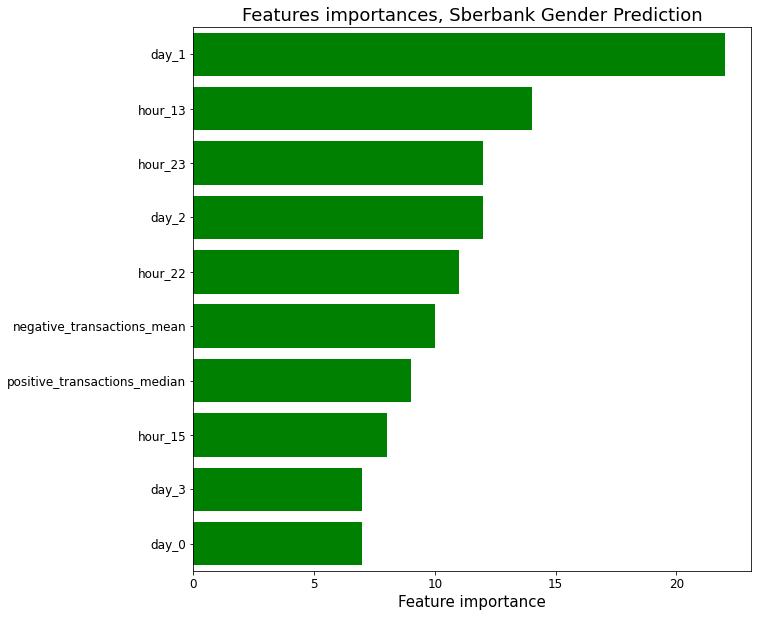

In [88]:
draw_feature_importances(clf, 10)

### Вывод:  
Добавление новых переменных улучшило наши результаты ROC AUC с 62.2% до 67.4%, на тестовой выборке результат будет аналогичным, так что мы явно не переобучились. При этом есть куда стремиться!

### Теперь попытаемся преодолеть порог в 80%

Добавим как признаки транзакции по определенным типам и mcc-кодам отдельно траты и поступления. Будем работать со всей выборкой, чтобы зафиксировать все возможные столбцы по клиентам для тренировочной и тестовой выборок.

In [89]:
def features_creation_advanced_2(x): 
    features = []
    features.append(pd.Series(x['day'].value_counts(normalize=True).add_prefix('day_')))
    features.append(pd.Series(x['hour'].value_counts(normalize=True).add_prefix('hour_')))
    features.append(pd.Series(x['night'].value_counts(normalize=True).add_prefix('night_')))
    features.append(pd.Series(x[x['amount']>0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('positive_transactions_')))
    features.append(pd.Series(x[x['amount']<0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('negative_transactions_')))
    a = pd.DataFrame(x[x['amount']<0].groupby('tr_type').amount.agg(['min', 'max', 'mean', 'count']).add_prefix('neg_trans_')).unstack(-1)
    a.index = ['{}_{}'.format(i, j) for i, j in a.index]
    features.append(a)
    b = pd.DataFrame(x[x['amount']>0].groupby('tr_type').amount.agg(['min', 'max', 'mean', 'count']).add_prefix('pos_trans_')).unstack(-1)
    b.index = ['{}_{}'.format(i, j) for i, j in b.index]
    features.append(b)
    c = pd.DataFrame(x[x['amount']<0].groupby('mcc_code').amount.agg(['min', 'max', 'mean', 'count']).add_prefix('neg_trans_mcc_code')).unstack(-1)
    c.index = ['{}_{}'.format(i, j) for i, j in c.index]
    features.append(c)
    d = pd.DataFrame(x[x['amount']>0].groupby('mcc_code').amount.agg(['min', 'max', 'mean', 'count']).add_prefix('pos_trans_mcc_code')).unstack(-1)
    d.index = ['{}_{}'.format(i, j) for i, j in d.index]
    features.append(d)
                              
    return pd.concat(features)

In [90]:
# Добавим базовые признаки в исходный датасет
transactions['day'] = transactions['tr_datetime'].str.split().apply(lambda x: int(x[0]) % 7)
transactions['hour'] = transactions['tr_datetime'].apply(lambda x: re.search(' \d*', x).group(0)).astype(int)
transactions['night'] = ~transactions['hour'].between(6, 22).astype(int)+2

In [91]:
data = transactions.groupby(transactions.index)\
                               .progress_apply(features_creation_advanced_2).unstack(-1)
data_train = data.join(gender_train, how='inner')
data_test = data.join(gender_test, how='inner')

Progress::   0%|          | 0/15000 [00:00<?, ?it/s]

In [92]:
#Выделим отдельно target:
target = data_train['gender']
data_train.drop('gender', axis=1, inplace=True)

In [93]:
cv_score(params, data_train, target)

Cross-validation, ROC AUC: 0.876+-0.007, Trees: 321


In [94]:
def fit_(params: dict, num_trees: int, train: pd.DataFrame, target: pd.Series) -> tuple:
    '''
    Построение модели
    '''
    params['learning_rate'] = params['eta']
    clf = xgb.train(params, xgb.DMatrix(train.values, target, feature_names=list(train.columns)), 
                    num_boost_round=num_trees, maximize=True)
    return clf

In [95]:
### Число деревьев для XGBoost имеет смысл выятавлять по результатам на кросс-валидации 
clf = fit_(params, 126, data_train, target)

In [96]:
importances = dict(sorted(clf.get_score().items(), key=lambda x: x[1])[-500:])
#importances.values()
cols = [key  for key in importances.keys() if key != 'gender']

In [97]:
#Проверим сколько признаков достаточно, чтобы получить такой результат:
for i in tqdm_notebook(np.linspace(10, 156, 16).astype(int)):
    df_train = data_train.loc[:,cols[-i:]]
    print('{} columns'.format(i))
    cv_score(params, df_train, target)

  0%|          | 0/16 [00:00<?, ?it/s]

10 columns
Cross-validation, ROC AUC: 0.804+-0.007, Trees: 185
19 columns
Cross-validation, ROC AUC: 0.836+-0.006, Trees: 142
29 columns
Cross-validation, ROC AUC: 0.860+-0.007, Trees: 229
39 columns
Cross-validation, ROC AUC: 0.860+-0.006, Trees: 220
48 columns
Cross-validation, ROC AUC: 0.868+-0.005, Trees: 269
58 columns
Cross-validation, ROC AUC: 0.868+-0.006, Trees: 272
68 columns
Cross-validation, ROC AUC: 0.869+-0.006, Trees: 282
78 columns
Cross-validation, ROC AUC: 0.871+-0.007, Trees: 297
87 columns
Cross-validation, ROC AUC: 0.870+-0.006, Trees: 263
97 columns
Cross-validation, ROC AUC: 0.874+-0.006, Trees: 329
107 columns
Cross-validation, ROC AUC: 0.874+-0.006, Trees: 279
117 columns
Cross-validation, ROC AUC: 0.875+-0.005, Trees: 358
126 columns
Cross-validation, ROC AUC: 0.877+-0.006, Trees: 403
136 columns
Cross-validation, ROC AUC: 0.874+-0.005, Trees: 269
146 columns
Cross-validation, ROC AUC: 0.876+-0.007, Trees: 348
156 columns
Cross-validation, ROC AUC: 0.875+-0.00

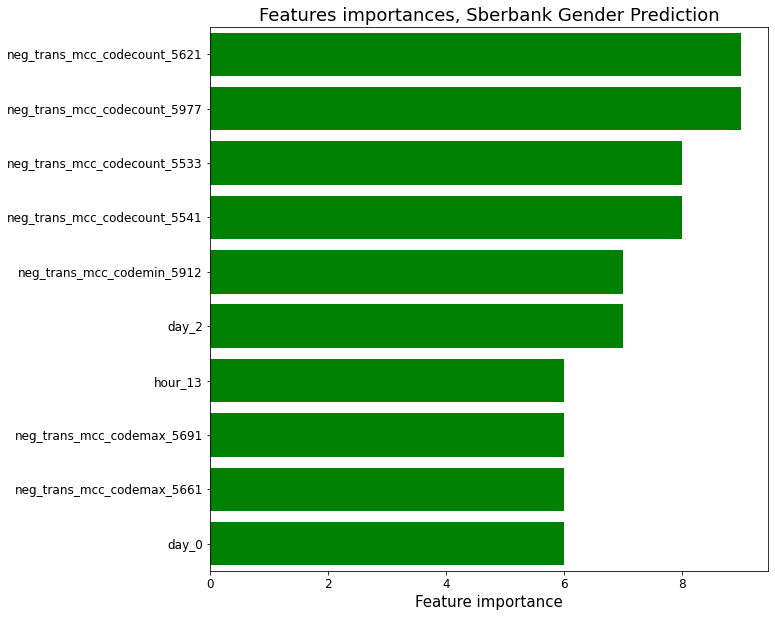

In [98]:
# Посмотрим на самые важные признаки
draw_feature_importances(clf, 10)

In [99]:
#Обучим модель и подготовим сабмит на выбранных признаках:
cols = cols[-146:].copy()
data_train, data_test = data_train.loc[:, cols], data_test.loc[:,cols]
clf, submission = fit_predict(params, 375, data_train, data_test, target)

In [100]:
#Запишем файл для отправки на платформу:
submission.to_csv('final_submission.csv')